In [54]:
import os
%matplotlib inline
import math
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt, cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm

In [55]:
image_path = "urban grids/maze2.png"
append = "maze-rew"
output_folder = "output/"
output_name = f"vi-{append}"
if not os.path.exists(output_folder+output_name):
    os.makedirs(output_folder+output_name)

In [56]:
BLACK = [0, 0, 0]
WHITE = [255, 255, 255]
BLUE = [0, 0, 255]
GREEN = [0, 255, 0]
YELLOW = [255, 255, 0]

FREE_CELL = 0
OBSTACLE = 1
START = 2
GOAL = 3

In [57]:
is_using_distribution = True
base_reward = -5
antenna_reward = -1

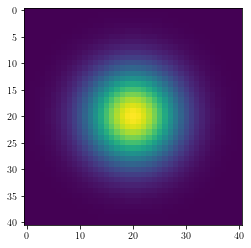

In [58]:
radius = 20
sigma = 6
mu = 0
from scipy.stats import multivariate_normal

gauss2d = multivariate_normal([mu, mu], [[sigma ** 2, 0], [0, sigma ** 2]])
X, Y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
antenna_distribution = gauss2d.pdf(pos)
antenna_distribution -= antenna_distribution.min()
antenna_distribution *= abs(base_reward - antenna_reward) / antenna_distribution.max()
plt.imshow(antenna_distribution)

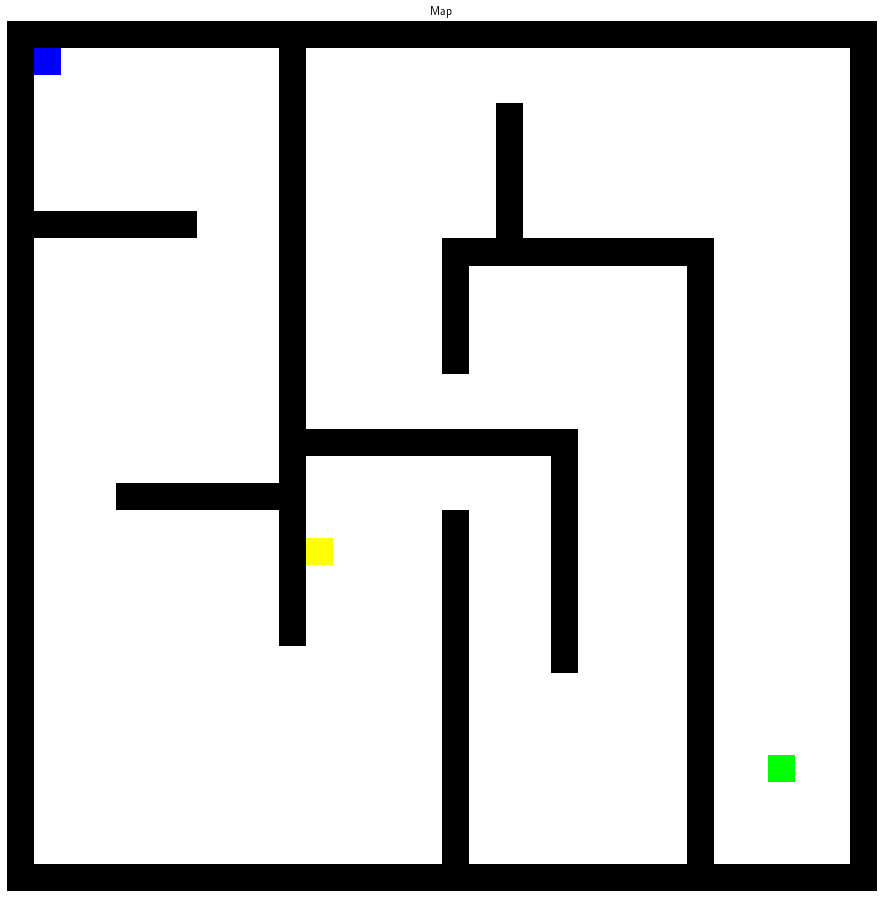

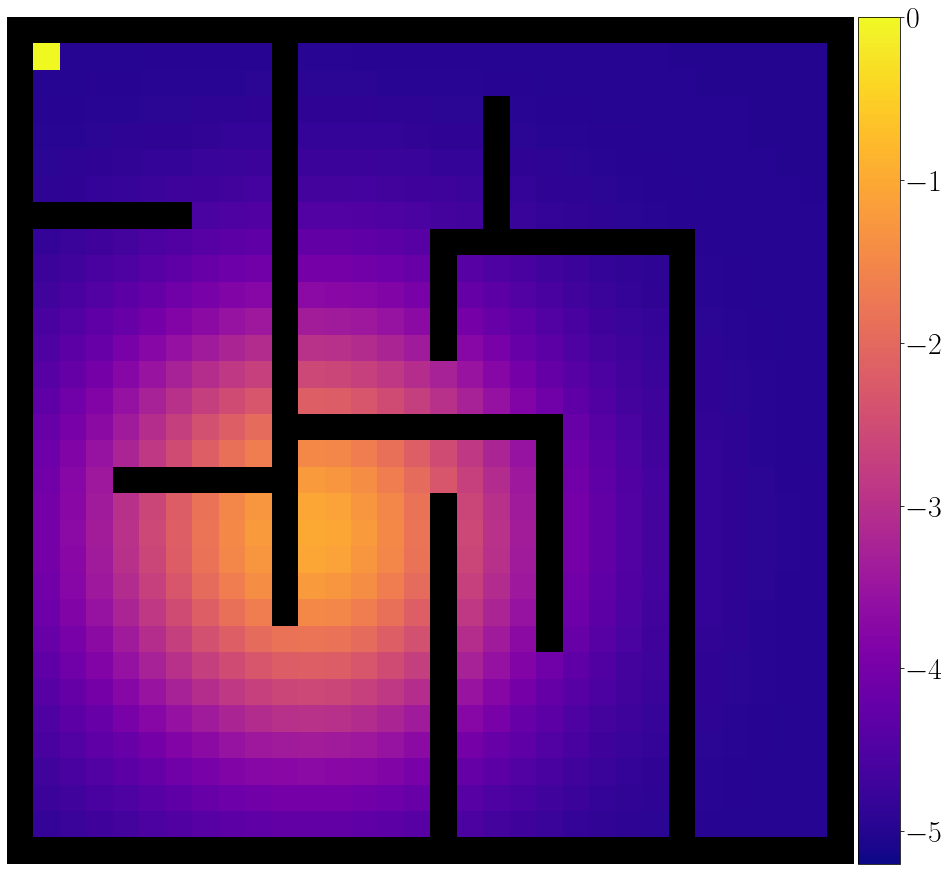

In [59]:
image = Image.open(image_path)
size = image.size
data = np.asarray(image)
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map')
ax.imshow(data)
cell_types = np.zeros(size, dtype=int)
c = np.zeros(size, dtype=np.float32)
antenna_indexes = []
for x in range(size[0]):
    for y in range(size[1]):
        cell = data[x, y, :]
        if np.array_equal(cell, BLACK):
            cell_types[x, y] = OBSTACLE
            c[x, y] = -100
        elif np.array_equal(cell, WHITE):
            cell_types[x, y] = FREE_CELL
            c[x, y] = base_reward
        elif np.array_equal(cell, GREEN):
            cell_types[x, y] = START
            c[x, y] = base_reward
        elif np.array_equal(cell, BLUE):
            cell_types[x, y] = GOAL
            c[x, y] = 1.0
        elif np.array_equal(cell, YELLOW):
            if is_using_distribution:
                #cell_types[x, y] = OBSTACLE
                antenna_indexes.append((x, y))
                #c[x, y] = -100
                c[x, y] = base_reward
            else:
                c[x, y] = antenna_reward
obstacle_map = np.where(cell_types == OBSTACLE, 0, 1).astype(np.float32)

start = np.copy(cell_types)
start = np.where(start != START, 0, start)
start = np.where(start == START, 1, start).astype(np.float32)

goal = np.copy(cell_types)
goal = np.where(goal != GOAL, 0, goal)
goal = np.where(goal == GOAL, 1, goal).astype(np.float32)

if len(antenna_indexes) > 0:
    map = np.zeros(c.shape)
    for x, y in antenna_indexes:
        x_min_radius = x if x <= radius else radius
        x_max_radius = radius + 1 if x + radius + 1 < size[0] else size[0] - x
        y_min_radius = y if y <= radius else radius
        y_max_radius = radius + 1 if y + radius + 1 < size[1] else size[1] - y
        distribution = antenna_distribution[radius - x_min_radius:radius + x_max_radius,
                       radius - y_min_radius:radius + y_max_radius]
        mask = obstacle_map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius]
        c[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution
        map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution

c[goal == 1] = 0
fig, ax = plt.subplots(figsize=(16, 16))
cmap = cm.get_cmap('plasma').copy()
cmap.set_under("black")
ax.axis('off')
im = ax.matshow(c, cmap=cmap, vmin=base_reward-0.2)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax).ax.tick_params(labelsize=30)

plt.savefig(f"{output_folder}/{output_name}/{output_name}_reward-map.png", bbox_inches='tight', dpi=300)

In [60]:
states = np.zeros(size, dtype=np.intp)
cell_types = cell_types.astype(int)
# states
it = np.nditer(states, flags=['multi_index'])
n_states = 1
while not it.finished:
    x, y = it.multi_index
    if cell_types[x, y] == OBSTACLE:
        states[x, y] = 1
    elif cell_types[x, y] != GOAL:
        n_states += 1
        states[x, y] = n_states
    else:
        states[x, y] = 0

    it.iternext()
n_states += 1


# actions
def is_out_of_bounds(new_index):
    return np.any(np.array(new_index) > (np.array(states.shape) - 1)) or np.any(np.array(new_index) < 0)


moves = [
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y - 1)) else (x - 1, y - 1),  # Up-Left
    lambda x, y: (np.clip(x - 1, 0, size[0] - 1), y),  # Up
    lambda x, y: (x, y) if is_out_of_bounds((x - 1, y + 1)) else (x - 1, y + 1),  # Up-Right
    lambda x, y: (x, np.clip(y - 1, 0, size[0] - 1)),  # Left
    lambda x, y: (x, y),  # Still
    lambda x, y: (x, np.clip(y + 1, 0, size[0] - 1)),  # Right
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y - 1)) else (x + 1, y - 1),  # Down-Left
    lambda x, y: (np.clip(x + 1, 0, size[0] - 1), y),  # Down
    lambda x, y: (x, y) if is_out_of_bounds((x + 1, y + 1)) else (x + 1, y + 1),  # Down-Right
]
n_actions = len(moves)
current_step = 0
gamma = 1.0
theta = 1e-6

In [61]:
def move(x, y, n_action):
    if cell_types[x, y] == GOAL:
        next_state = 0
        reward = 0
    elif cell_types[x, y] == OBSTACLE:
        next_state = 1
        reward = -100
    else:
        new_index = moves[n_action](x, y)
        next_state = states[new_index] if cell_types[new_index] != OBSTACLE else states[x, y]
        reward = -100 if cell_types[new_index] == OBSTACLE else c[x,y] if n_action in [1,3,5,7] else math.sqrt(2) * c[x,y]
    return int(next_state), reward

In [62]:
finished = False


def generator():
    i = 1
    while not finished:
        yield i
        i += 1

In [63]:
def values_to_V(val):
    vv = np.zeros(n_states)
    it = np.nditer(states, flags=['multi_index'])
    while not it.finished:
        x, y = it.multi_index
        vv[states[x, y]] = val[x, y]
        it.iternext()
    return vv


In [64]:
def gen_apm():
    A = 1 / 18 * np.ones(8)
    A[[0, 2]] = 1 / 6
    A[1] = 1 / 3
    apm = 1 / 18 * np.ones((9, 9))
    apm[4] = 1 / 16 * np.ones(9)
    apm[4, 4] = 1 / 2
    for i in [0, 1, 2, 5, 8, 7, 6, 3]:
        apm[i, [3, 5]] = A[[0, 4]]
        apm[i, :3] = A[1:4]
        apm[i, 6:] = A[5:8][::-1]
        A = np.roll(A, 1)
    return np.reshape(apm, (9, 3, 3))


aps = gen_apm()

In [65]:
def has_obstacles_nearby(x, y):
    obstacles = []
    for i in range(n_actions):
        if cell_types[moves[i](x, y)] == 1:
            obstacles.append(i)
    return obstacles


def state_trnstn_distr(x, y, action):
    obstacles = obstacle_map[x - 1:x + 2, y - 1:y + 2]
    ap = np.copy(aps[action])
    n_obs = 9 - np.count_nonzero(obstacles)
    if n_obs:
        prob = np.sum(ap[np.nonzero(obstacles == 0)])
        ap *= obstacles
        ap[1, 1] += prob
    return ap


In [66]:
next_states = np.zeros((size[0], size[1], 3, 3), dtype=np.intp)
rewards = np.zeros(next_states.shape)
probs = np.zeros((n_actions, size[0], size[1], 3, 3))
iter = np.nditer(states, flags=['multi_index'])
while not iter.finished:
    x, y = iter.multi_index

    nexts = np.zeros(n_actions)
    rews = np.zeros(n_actions)
    for a in range(n_actions):
        nexts[a], rews[a] = move(x, y, a)

        if x in range(1, size[1] - 1) and y in range(1, size[0] - 1):
            probs[a, x, y, :, :] = state_trnstn_distr(x, y, a)

    rewards[x, y, :, :] = rews.reshape((3,3))
    next_states[x, y, :, :] = np.reshape(nexts, (3, 3))
    iter.iternext()

In [67]:
finished = False
p_bar = tqdm(generator(), desc="t")
values = np.zeros(obstacle_map.shape)
Vs = np.zeros((1, n_states))
policies = np.zeros((1,) + obstacle_map.shape)
policies2 = np.zeros((1, n_actions,) + obstacle_map.shape)
policy = np.zeros(obstacle_map.shape)
policy2 = np.zeros((n_actions,) + obstacle_map.shape)
V = np.zeros(n_states)
diffs = np.zeros(1)
for t in p_bar:
    delta = 0.0
    v = np.copy(values)
    Q = np.sum((rewards + gamma * V[next_states]) * probs, (3, 4))
    values = np.max(Q, 0)
    V = values_to_V(values)
    Vs = np.append(Vs, [V], 0)
    # V[0] = 0
    delta = max(delta, np.max(np.abs(v - values)))
    diffs = np.append(diffs, delta)
    policy = np.argmax(Q, 0)
    policy2 = np.copy(Q)
    if policy.shape == obstacle_map.shape:
        policies = np.append(policies, [policy], axis=0)
        policies2 = np.append(policies2, [policy2], axis=0)

    p_bar.set_description(f"{delta}")
    if delta < theta:
        finished = True

t: 0it [00:00, ?it/s]

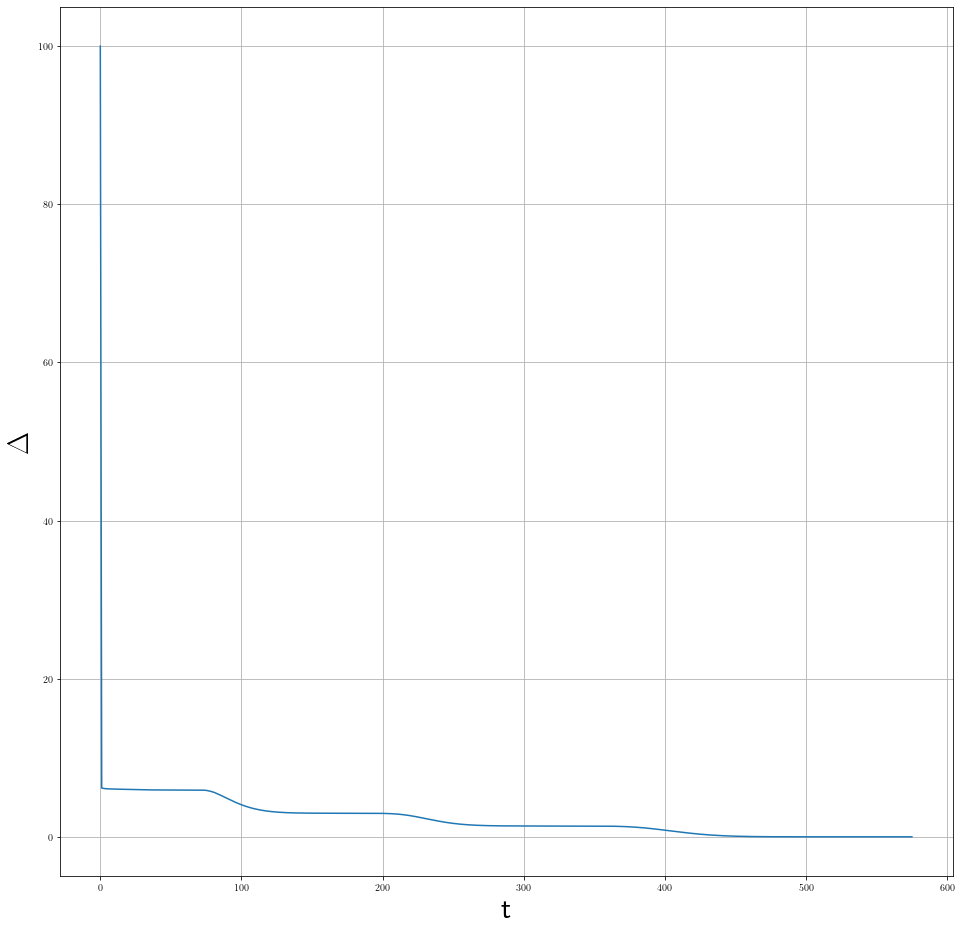

In [68]:
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams.update({
    "text.usetex": True})
ax.plot(range(policies.shape[0] - 1), diffs[1:])
ax.set_xlabel("t", fontsize=30)
ax.set_ylabel("$\Delta$", fontsize=30)
ax.grid("on")
plt.savefig(f"{output_folder}/{output_name}/{output_name}_deltas", bbox_inches='tight', dpi=300)


In [69]:
def arrowedLine(im, ptA, ptB, width=1, color=(0, 0, 0)):
    """Draw line from ptA to ptB with arrowhead at ptB"""
    # Get drawing context
    draw = ImageDraw.Draw(im)
    # Draw the line without arrows


    # Now work out the arrowhead
    # = it will be a triangle with one vertex at ptB
    # - it will start at 95% of the length of the line
    # - it will extend 8 pixels either side of the line
    x0, y0 = ptA
    x1, y1 = ptB
    # Now we can work out the x,y coordinates of the bottom of the arrowhead triangle
    xb = 0.8 * (x1 - x0) + x0
    yb = 0.8 * (y1 - y0) + y0
    draw.line([ptA, (xb,yb)], width=width, fill=color)
    # Work out the other two vertices of the triangle
    # Check if line is vertical
    if x0 == x1:
        vtx0 = (xb - 5, yb)
        vtx1 = (xb + 5, yb)
    # Check if line is horizontal
    elif y0 == y1:
        vtx0 = (xb, yb + 5)
        vtx1 = (xb, yb - 5)
    else:
        alpha = math.atan2(y1 - y0, x1 - x0) - 90 * math.pi / 180
        a = 8 * math.cos(alpha)
        b = 8 * math.sin(alpha)
        vtx0 = (xb + a, yb + b)
        vtx1 = (xb - a, yb - b)

    #draw.point((xb,yb), fill=(255,0,0))    # DEBUG: draw point of base in red - comment out draw.polygon() below if using this line
    #im.save('DEBUG-base.png')              # DEBUG: save

    # Now draw the arrowhead triangle
    draw.polygon([vtx0, vtx1, ptB], fill=color)
    return im

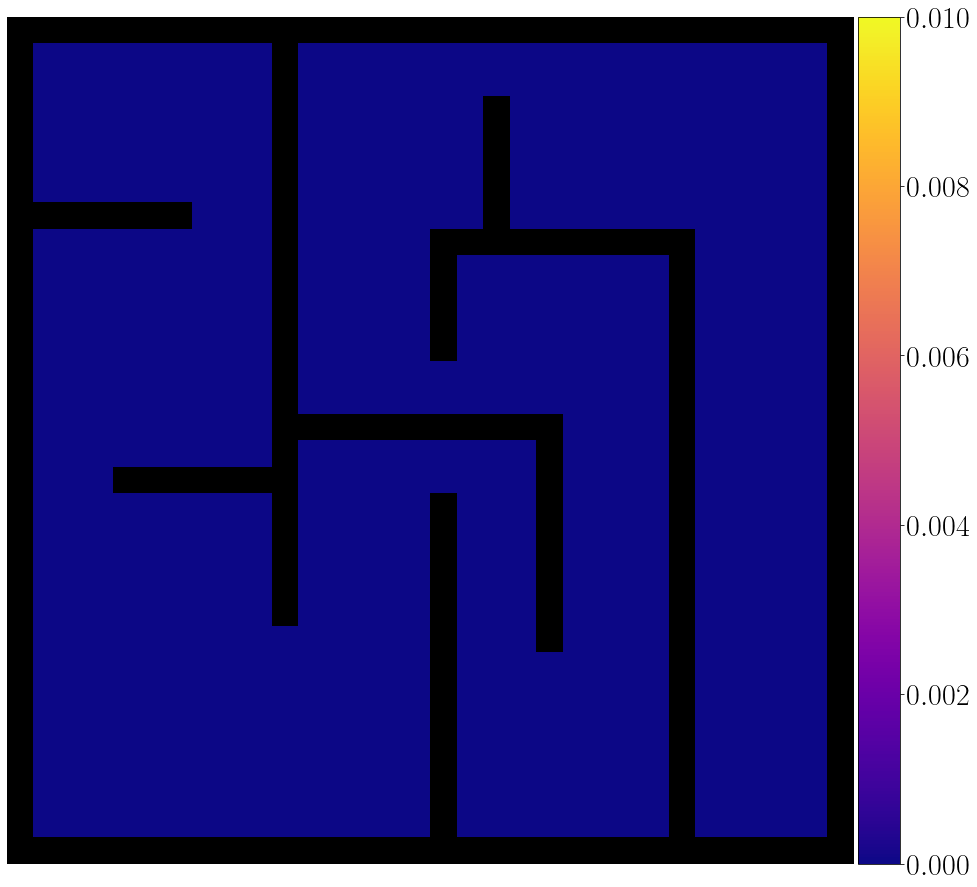

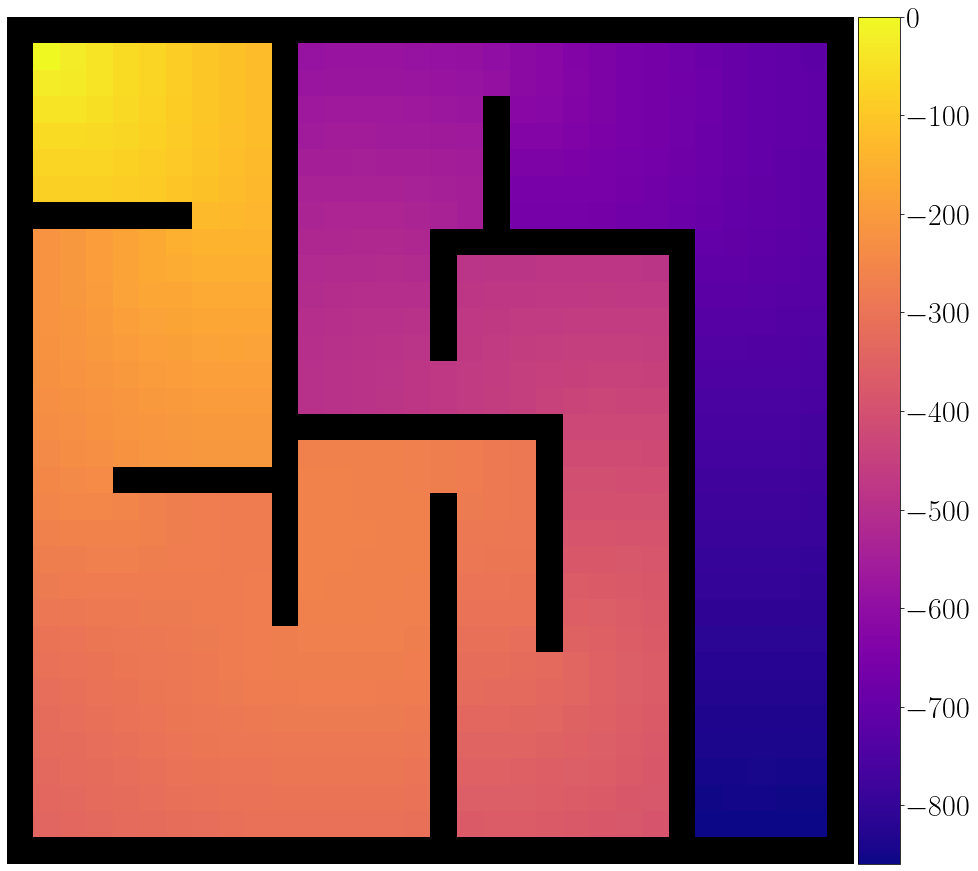

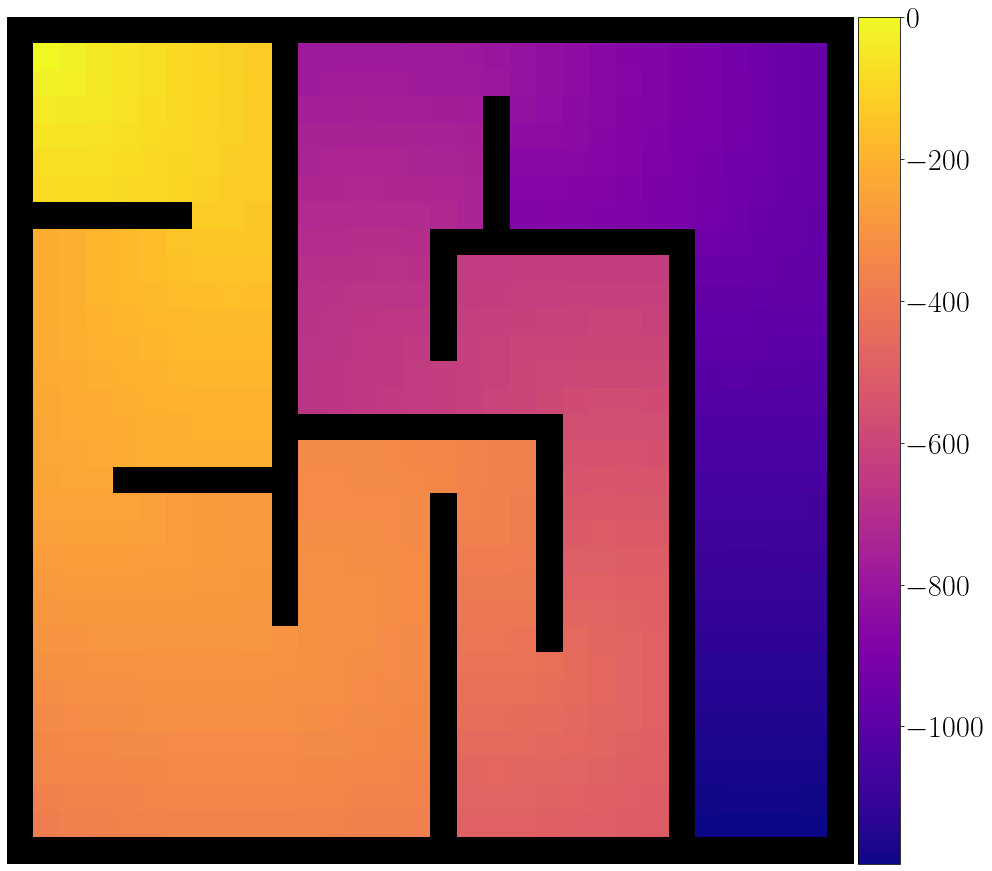

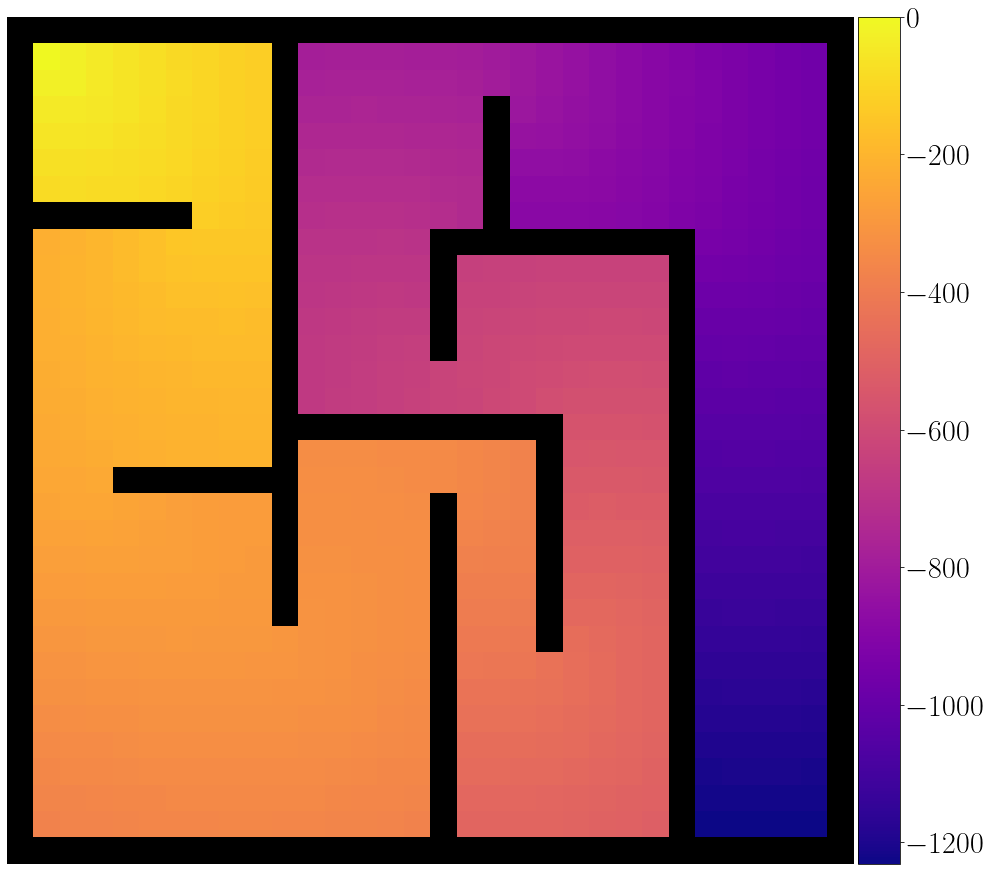

In [70]:
arrws = [
    '↖', '↑', '↗',
    '←', ' ', '→',
    '↙', '↓', '↘',
]
pixel_size = 200
font_color = (0, 0, 0)


def center(x, y):
    return np.array((x + 0.5, y + 0.5))

rel_pos = 0.45
diag_pos = rel_pos * math.sin(math.pi / 4)

points = [
    (-diag_pos, -diag_pos),  # Up-Left
    (0.0, -rel_pos),  # Up
    (diag_pos, -diag_pos),  # Up-Right
    (-rel_pos, 0.0),  # Left
    (0.0, 0.0),  # Still
    (rel_pos, 0.0),  # Right
    (-diag_pos, diag_pos),  # Down-Left
    (0.0, rel_pos),  # Down
    (diag_pos, diag_pos),  # Down-Right
]


def pol2(polic):
    img = Image.new('RGB', (pixel_size * size[0], pixel_size * size[1]), color=(255, 255, 255))
    it = np.nditer(states, flags=['multi_index'])
    canvas = ImageDraw.Draw(img)
    while not it.finished:
        x, y = it.multi_index
        if cell_types[x, y] == OBSTACLE:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=font_color)
        elif cell_types[x, y] == GOAL:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=tuple(BLUE))

        else:
            if cell_types[x, y] == START:
                canvas.rectangle(
                        [((y + 1) * pixel_size, (x + 1) * pixel_size),
                         ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                        fill=tuple(GREEN))
            best_actions = np.argwhere(polic[:, x, y] == np.amax(polic[:, x, y]))
            for a in best_actions.flatten().tolist():
                cnt = center(y, x)
                b = center(y, x)+np.array(points[int(a)])

                img = arrowedLine(img, tuple(cnt*pixel_size), tuple(b*pixel_size), width=5,
                                  color=font_color)
        it.iternext()
    return img

for i in range(policies.shape[0] - 1):
    space = np.linspace(0, policies.shape[0] - 2, 4, dtype=int)
    if i in space:
        pol2(policies2[:-1][i]).save(f"{output_folder}/{output_name}/{output_name}_policy_{i}.png")
        fig, ax = plt.subplots(figsize=(16, 16))
        cmap = cm.get_cmap('plasma').copy()
        cmap.set_over("black")
        ax.axis('off')
        vv = np.copy(Vs[:-1][i])
        vv[1] = 0
        im = ax.matshow(vv[states] + (1 - obstacle_map), cmap=cmap, vmax=0.01)
        # for (i, j), z in np.ndenumerate(Vs[i+1][states]):
        #     ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax).ax.tick_params(labelsize=30)
        plt.savefig(f"{output_folder}/{output_name}/{output_name}_values_{i}.png", bbox_inches='tight', dpi=300)


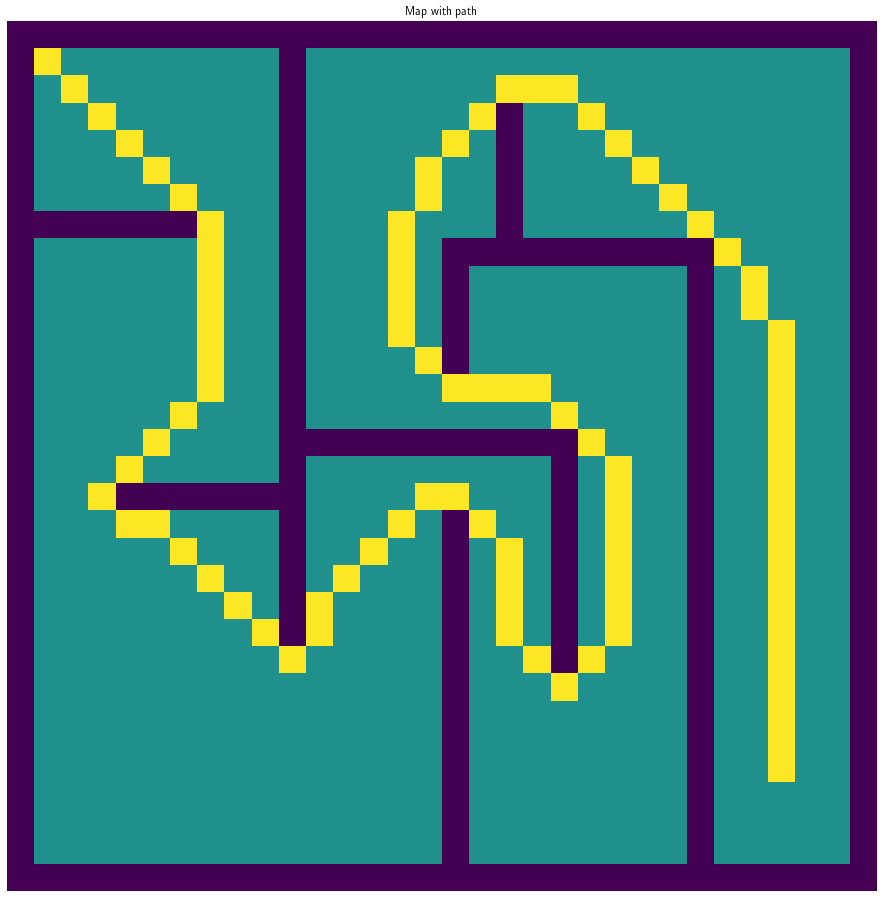

In [71]:
current_position = np.transpose(np.nonzero(cell_types == START))[0]
path = np.zeros(obstacle_map.shape)
while True:
    x = current_position[0]
    y = current_position[1]
    state = int(states[x, y])
    if path[x, y] == 1 or state == 0:
        path[x, y] = 1
        break
    path[x, y] = 1
    current_position = moves[int(policy[x, y])](x, y)
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(obstacle_map + path)

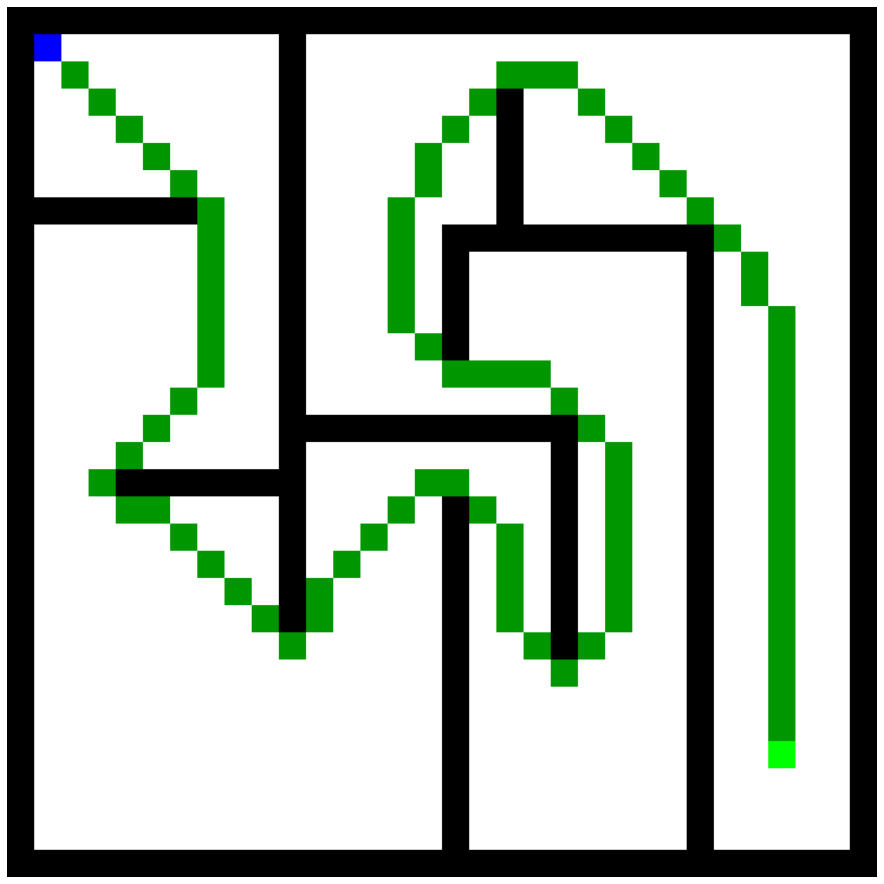

In [72]:
map_with_path = obstacle_map + path
pixel_size = 100
img = Image.new('RGB', (pixel_size * size[0], pixel_size * size[1]), color=(255, 255, 255))
canvas = ImageDraw.Draw(img)
for x, row in enumerate(map_with_path):
    for y, value in enumerate(row):
        if cell_types[x,y] == GOAL:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=tuple(BLUE))
        elif cell_types[x,y] == START:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=tuple(GREEN))
        elif int(value) == 0:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=tuple(BLACK))
        elif int(value) == 1:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=tuple(WHITE))
        elif int(value) == 2:
            canvas.rectangle(
                    [((y + 1) * pixel_size, (x + 1) * pixel_size),
                     ((y + 1) * pixel_size - pixel_size, (x + 1) * pixel_size - pixel_size)],
                    fill=(0,150,0))
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.imshow(img)
img.save(f"{output_folder}/{output_name}/{output_name}.png")